In [1]:
import pynbody
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#galaxy_masses=pd.DataFrame()
#BH_halos=pd.DataFrame()
snap_id=0
global iords
iords=pd.read_csv('csvdata/iords.csv',index_col='snap')

In [27]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings

from pynbody.analysis import profile, angmom, halo
from pynbody import filt, units, config, array
from pynbody.plot.sph import image
from pynbody import units as _units
import pandas as pd
import pynbody as pynbody

global iords
iords=pd.read_csv('csvdata/iords.csv',index_col='snap')

# coding: utf-8

# In[ ]:
def combine(r, g, b, magnitude_range, brightest_mag=None):
    # flip sign so that brightest pixels have biggest value
    r = -r
    g = -g
    b = -b

    if brightest_mag is None:
        brightest_mag = []

        # find something close to the maximum that is not quite the maximum
        for x in r, g, b:
            ordered = np.sort(x.flatten())
            brightest_mag.append(ordered[-len(ordered) / 5000])

        brightest_mag = max(brightest_mag)
    else:
        brightest_mag = -brightest_mag

    rgbim = np.zeros((r.shape[0], r.shape[1], 3))
    rgbim[:, :, 0] = bytscl(r, brightest_mag - magnitude_range, brightest_mag)
    rgbim[:, :, 1] = bytscl(g, brightest_mag - magnitude_range, brightest_mag)
    rgbim[:, :, 2] = bytscl(b, brightest_mag - magnitude_range, brightest_mag)
    return rgbim, -brightest_mag

def convert_to_mag_arcsec2(image):
    assert image.units=="pc^-2"
    pc2_to_sqarcsec = 2.3504430539466191e-09
    return -2.5*np.log10(image*pc2_to_sqarcsec)

def render(sim, filename=None,
           r_band='i', g_band='v', b_band='u',
           r_scale=0.5, g_scale=1.0, b_scale=1.0,
           dynamic_range=2.0,
           mag_range=None,
           width=50,
           starsize=None,
           plot=True, axes=None, ret_im=False, clear=True,
           ret_range=False):
    '''
    Make a 3-color image of stars.

    The colors are based on magnitudes found using stellar Marigo
    stellar population code.  However there is no radiative transfer
    to account for dust.

    Returns: If ret_im=True, an NxNx3 array representing an RGB image

    **Optional keyword arguments:**

       *filename*: string (default: None)
         Filename to be written to (if a filename is specified)

       *r_band*: string (default: 'i')
         Determines which Johnston filter will go into the image red channel

       *g_band*: string (default: 'v')
         Determines which Johnston filter will go into the image green channel

       *b_band*: string (default: 'b')
         Determines which Johnston filter will go into the image blue channel

       *r_scale*: float (default: 0.5)
         The scaling of the red channel before channels are combined

       *g_scale*: float (default: 1.0)
         The scaling of the green channel before channels are combined

       *b_scale*: float (default: 1.0)
         The scaling of the blue channel before channels are combined

       *width*: float in kpc (default:50)
         Sets the size of the image field in kpc

       *starsize*: float in kpc (default: None)
         If not None, sets the maximum size of stars in the image

       *ret_im*: bool (default: False)
         if True, the NxNx3 image array is returned

       *ret_range*: bool (default: False)
         if True, the range of the image in mag arcsec^-2 is returned.

       *plot*: bool (default: True)
         if True, the image is plotted

       *axes*: matplotlib axes object (deault: None)
         if not None, the axes object to plot to

       *dynamic_range*: float (default: 2.0)
         The number of dex in luminosity over which the image brightness ranges

       *mag_range*: float, float (default: None)
         If provided, the brightest and faintest surface brightnesses in the range,
         in mag arcsec^-2. Takes precedence over dynamic_range.
    '''

    if isinstance(width, str) or issubclass(width.__class__, _units.UnitBase):
        if isinstance(width, str):
            width = _units.Unit(width)
        width = width.in_units(sim['pos'].units, **sim.conversion_context())

    if starsize is not None:
        smf = filt.HighPass('smooth', str(starsize) + ' kpc')
        sim.s[smf]['smooth'] = array.SimArray(starsize, 'kpc', sim=sim)

    r = image(sim.s, qty=r_band + '_lum_den', width=width, log=False,
              units="pc^-2", clear=False, noplot=True) * r_scale
    g = image(sim.s, qty=g_band + '_lum_den', width=width, log=False,
              units="pc^-2", clear=False, noplot=True) * g_scale
    b = image(sim.s, qty=b_band + '_lum_den', width=width, log=False,
              units="pc^-2", clear=False, noplot=True) * b_scale

    # convert all channels to mag arcsec^-2


    r=pynbody.plot.stars.convert_to_mag_arcsec2(r)
    g=pynbody.plot.stars.convert_to_mag_arcsec2(g)
    b=pynbody.plot.stars.convert_to_mag_arcsec2(b)


    #r,g,b = nw_scale_rgb(r,g,b)
    #r,g,b = nw_arcsinh_fit(r,g,b)

    if mag_range is None:
        rgbim, mag_max = pynbody.plot.stars.combine(r, g, b, dynamic_range*2.5)
        mag_min = mag_max + 2.5*dynamic_range
    else:
        mag_max, mag_min = mag_range
        rgbim, mag_max = pynbody.plot.stars.combine(r, g, b, mag_min - mag_max, mag_max)

    if plot:
        if clear:
            plt.clf()
        if axes is None:
            axes = plt.gca()

        if axes:
            axes.imshow(
                rgbim[::-1, :], extent=(-width / 2, width / 2, -width / 2, width / 2))
            axes.set_xlabel('x [' + str(sim.s['x'].units) + ']')
            axes.set_ylabel('y [' + str(sim.s['y'].units) + ']')
            plt.draw()

    if filename:
        plt.axis('off')
        plt.savefig(filename, dpi=1600, figsize=(25,25),bbox_inches='tight')

    if ret_im:
        return rgbim




    if ret_range:
        return mag_max, mag_min

def loader(path):
    '''returns snapshot and halo'''
    snap=pynbody.load(path)
    snap.physical_units()
    h=snap.halos()
    return snap,h

def BH_finder(snap):
    '''returns subsnap of black holes'''
    return snap.star[pynbody.filt.BandPass('tform','-15 Gyr','0 Gyr')]

def do_all(snap_id):
    path='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(snap_id,snap_id)
    snap,h=loader(path)
    BH=BH_finder(snap)
    #BH_arm=BH[pynbody.filt.BandPass('amiga.grp',2,15)]
    
    print 'BH iords: %s'%(BH['iord'])
    
    return snap, h, BH

def analysis(halo, view='asis'):
    '''center snap on halo's center of mass (angmom gives errors if there aren't enough pixels). 
    view=1 for face on, 2 for side on, anything else will leave it as is'''
    if view=='faceon':
        pynbody.analysis.angmom.faceon(halo)
    elif view=='sideon':
        pynbody.analysis.angmom.sideon(halo)
    else:
        pynbody.analysis.halo.center(halo)

def adjust_csv_index(df):
    df=df.rename(columns={'Unnamed: 0':'snap'})
    df=df.set_index('snap')
    
def add_mass_columns(hgrpid, grpid, snap_id):
    '''returns row with gas, stellar, and total masses for one halo tracked through time'''
    df=pd.DataFrame([[hgrpid.g['mass'].sum(), hgrpid.s['mass'].sum(), hgrpid['mass'].sum()]], index=[snap_id], columns=['H[%d] Gas'%(grpid),'H[%d] Star'%(grpid),'H[%d] Total'%(grpid)])
    df.units='Msol'
    return df
    
def mass_df(h, BHgrp, snap_id):
    df=pd.DataFrame()
    for i in BHgrp:
        df=pd.concat([df, add_mass_columns(h[i], i, snap_id)], axis=1, join='outer')
    df.units='Msol'
    return df
    
def galaxy_df(snap_id,h,BHgrp):
    '''snap_id_array[snap_id], h, np.unique(BH['amiga.grp'])'''
    galaxy_masses=pd.DataFrame()
    for i in snap_id:
        vars()['mass_%s'%(i)]=mass_df(h,BHgrp,i)
        galaxy_masses=galaxy_masses.append(vars()['mass_%s'%(i)])
    return galaxy_masses
    if save==True:
        galaxy_masses.to_csv('csvdata/%s_galaxy_masses.csv'%(snap_id))
        
def BH_halo_add(snap_id, BH, BH_halos):
    '''snap_id_array[snap_id], BH, BH_halos'''
    df=pd.DataFrame({'%s halo groups'%(snap_id):BH['amiga.grp'],'%s iords'%(snap_id):BH['iord']})
    BH_halos=pd.concat([BH_halos, df], axis=1, join='outer')
    return BH_halos

def load_snap_csvs(snap_id):
    '''snap_id_array[snap_id]. load mass and iord csvs'''
    #masses=pd.DataFrame()
    masses=pd.read_csv('csvdata/galaxy_masses.csv',index_col='snap')
    iords=pd.DataFrame()
    iords=pd.read_csv('csvdata/iords.csv',index_col='snap')
    return masses,iords
    
def get_iords_df(iords, iords_list, masses, save=False):
    for i in iords_list:
        ind=0
        vars()['iord_%s'%(i)]=pd.DataFrame(columns=['gas', 'star', 'total'])
        iords_temp=iords[i].dropna()
        vars()['iord_%s'%(i)]['halo']=iords[i]
        for j in iords_temp.index:
            if pd.notnull(iords.at[j,i]):
                temp=[masses.at[j,'H[%s] Gas'%(int(iords.at[j,i]))],masses.at[j,'H[%s] Star'%(int(iords.at[j,i]))],masses.at[j,'H[%s] Total'%(int(iords.at[j,i]))]]
            if (pd.notnull(temp)).any():
                vars()['iord_%s'%(i)].loc[int(iords_temp.index[ind]),['gas','star','total']]=temp
            else: continue
            ind=ind+1
            vars()['iord_%s'%(i)]=vars()['iord_%s'%(i)].fillna(0)
            if save==True:
                vars()['iord_%s'%(i)].to_csv('csvdata/iord_%s.csv'%(i))
                
def cycle_snap_id_array(snap_id_array,iords_list, h):
    '''loads each snap in snap_id_array and stores values to existing dataframes and saves as csvs(not as variable, so reload csv). Send snap_id_array, time dataframe, iords_list.
    Currently set to retrieve time[Gyr], z, BH[r], BH[mass]
    WARNING: This is going to be a long wait
    Note: can send partial arrays'''
    time=pd.DataFrame(index=snap_id_array, columns=['time[Gyr]', 'z'])
    for j in snap_id_array:
        path='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(j,j)
        snap,h=loader(path)
        time.loc[j]['time[Gyr]']=snap.properties['time'].in_units('Gyr')
        time.loc[j]['z']=snap.properties['z']
        time.to_csv('csvdata/time.csv')
        BH=BH_finder(snap)
        for i in iords_list:
            temp=BH[np.where(BH['iord']==int(i))]['mass']
            if len(temp)>0:
                vars()['iord_%s'%(i)].loc[int(j),'BH']=temp
                analysis(h[int(np.unique(BH[np.where(BH['iord']==int(i))]['amiga.grp']))])
                vars()['iord_%s'%(i)].loc[int(j),'r[kpc]']=np.sqrt((BH['pos']**2).sum(axis=1))
            vars()['iord_%s'%(i)].to_csv('csvdata/iord_%s.csv'%(i), index=False)
            
    #for j in snap_id_array:
    #    path='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(j,j)
    #    snap,h=loader(path)
    #    BH=BH_finder(snap)
    #    BH_arm=BH[pynbody.filt.BandPass('amiga.grp',2,200)]
    #    for i in BH_arm['iord']:
    #        ind=np.where(BH_arm['iord']==i)
    #        halo_id=BH_arm[ind]['amiga.grp']
    #        pynbody.analysis.halo.center(h[halo_id],mode='com')
    #        temp=np.sqrt((BH_arm[ind]['pos']**2).sum(axis=1))
    #        vars()['i_%s_data'%(i)].loc[int(snap_id_array[snap_id]),'r[kpc]']=temp
    #        pynbody.new('subsnaps/h%s_s%s'%(halo_id,j))

def get_orbits(iords_list, save=False):
    '''read .orbit file and convert to dataframe. long run time!'''
    cols=['iord', 'time', 'stepNumber', 'mass','xPos', 'yPos', 'zPos','xVel','yVel','zVel','pot','accRate','delM','FB_E_released','dt','scalefactor']
    orbit_file=pd.read_csv('/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.orbit', header=None, sep=' ', index_col=False,names=cols)
    matches=np.isin(np.array(orbit_file['iord']), np.array(iords_list))
    bhorbit=orbit_file[matches]
    if save==True:
        bhorbit.to_csv('csvdata/bhorbit.csv', index=False)
    return bhorbit

def get_iorbits(iords_arm_list, save=True, filename='csvdata/i%s_orbit.csv'):
    '''return orbit dataframe for specified iord. long run time!'''
    bhorbit=get_orbits(iords_arm_list)
    for i in iords_arm_list:
        iord_id=int(i)
        mask=np.isin(np.array(bhorbit['iord']), i)
        i_orbit=bhorbit[mask]
        #mask2=np.isin(temp['stepNumber'], map(int, snap_id_array))
        i_orbit.loc[:,'accRate']=(i_orbit['accRate']*1.84793e16)/38759428183.8 #M_sol/yr
        i_orbit.loc[:,'accRate']=i_orbit['accRate']*((1.989*(10**33))/(3.9536*(10**7))) #ergs/s
        i_orbit.loc[:,'time']=(i_orbit['time']*38759428183.8)/10**9 #Gyr
        i_orbit.loc[:,'mass']=i_orbit['mass']*1.84793e16 #M_sol
        i_orbit.loc[:,'xPos']=i_orbit['xPos']*50000 #kpc
        i_orbit.loc[:,'yPos']=i_orbit['yPos']*50000 #kpc
        i_orbit.loc[:,'zPos']=i_orbit['zPos']*50000 #kpc
        i_orbit.loc[:,'bolo_lum']=i_orbit['accRate']*.1*((2.9979246*10**8)**2)
        i_orbit.loc[:,'x_lum']=i_orbit['bolo_lum']/88.99

        i_orbit=i_orbit.sort_values('time')
        if save==True:
            i_orbit.to_csv(filename%(iord_id), index=False)
        return i_orbit

def bin_down(iord_df,n=1000):
    '''
    bins down iord_df to a shorter df with n # of bins
    '''    
    bins=np.linspace(iord_df['time'].min(),iord_df['time'].max(),n)
    groups=iord_df.groupby(np.digitize(iord_df.time, bins))
    binned=groups.median()
    
    return binned
    
def plot_SFH(h, grpid, snap_id, c='k', save=True, mf=False, filename='plots/SFH/i_%s_SFH.png'): #%s_h[%s]_SFH.png'):
    '''plots SFH. Send halo array(h[grpid]), color(c=k) grpid, and snapshot you want to plot 
    Optional:save(default=True)
    #examples of iterative SFH:
    for i in np.unique(BH['amiga.grp']): #using black hole array
        plot_SFH(h,i,snap_id_array[snap_id], mf=False)
    for i in np.unique(iords[str(snap_id_array[snap_id])+' halo groups'].dropna()): #using iords array
        plot_SFH(h,i,snap_id_array[snap_id], mf=False)'''
    plt.clf()
    pynbody.plot.sfh(h[grpid].s,color=c, massform=mf);
    plt.title('%s_h[%s]_SFH'%(snap_id,grpid), y=1.14);
    if save==True:
        plt.savefig(filename,bbox_inches='tight', dpi=200);
        
def SFH(simstars, filename=None, massform=False, subplot=False, trange=False, bins=100, **kwargs):
    if subplot:
        plt=subplot
    trange=[simstars['tform'].in_units("Gyr").min(), simstars['tform'].in_units("Gyr").max()]
    binnorm=1e-9*bins/(trange[1]-trange[0])
    trangefilt=pynbody.filt.And(pynbody.filt.HighPass('tform', str(trange[0]) + ' Gyr'), pynbody.filt.LowPass('tform', str(trange[1]) + ' Gyr'))
    tforms=simstars[trangefilt]['tform'].in_units('Gyr')
    weight=simstars[trangefilt]['mass'].in_units('Msol')*binnorm

    sfhist, thebins, patches = plt.hist(tforms, weights=weight, bins=bins, histtype='step', **kwargs)
    
    if not subplot:
        plt.xlabel('Time [Gyr]', fontsize='large')
        plt.ylabel('SFR [M$_\odot$ yr$^{-1}$]', fontsize='large')
    else:
        plt.set_ylim(1.2 * np.min(sfhist), 1.2 * np.max(sfhist))
        
    return pynbody.array.SimArray(sfhist, "Msol yr**-1"), pynbody.array.SimArray(thebins, "Gyr")

def ihist(iord_df, wt,subplot=False, bins=100, **kwargs):
    if subplot:
        plt=subplot
    trange=[iord_df['time'].min(), iord_df['time'].max()]
    binnorm=1e-9*bins/(trange[1]-trange[0])
    weight=iord_df[wt]*binnorm

    hist,thebins,patches=plt.hist(iord_df['time'], weights=weight, bins=bins, histtype='step', **kwargs)
    
    if not subplot:
        plt.xlabel('Time [Gyr]', fontsize='large')
        plt.ylabel('whstfffffff', fontsize='large')
    else:
        plt.set_ylim(1.2 * np.min(hist), 1.2 * np.max(hist))
        
    return pynbody.array.SimArray(hist), pynbody.array.SimArray(thebins, "Gyr")

def plot_BH_pos(h, BH, attribute, cmap='Greys', w=100, lc='best',save=False, filename='plots/dg_adjTime/h%s_t%s_w%s.png'):
    '''plots position of black holes. Send halo array(h[grpid]), black hole array(BH),attribute 
    Optional: width/preferred scope(w) (default=100), colormap(default='Greys'), save(default=False)'''
    
    halo_id=int(np.unique(h['amiga.grp']))
    time=h.properties['time'].in_units('Gyr')
    
    pynbody.plot.image(h,qty=attribute,cmap=cmap, width=w, log=False)
    
    for i in np.where(BH['amiga.grp']==halo_id):
        plt.annotate('local max', xy=(2, 1), xytext=(3, 1.5))
    plt.xlim(-w/2,w/2)
    plt.ylim(-w/2,w/2)
    plt.title('Halo %s at %s Gyr'%(halo_id, round(time, 2)))
    plt.legend(fancybox=True, loc='lc')
    plt.tight_layout()

    if save==True:
        plt.savefig(filename%(halo_id, round(time, 2), w),bbox_inches='tight', dpi=200)
                
def iord_mass_plot(iord_df, iord_id, save=False, filename='plots/galaxy_masses/iord_%s_masses.png'):
    plt.hist(range(0,len(iord_df)), weights=iord_df['total'], bins=len(iord_df),width=.85, alpha=.3, histtype='bar', label='Total', color='#666666',rwidth=1, align='mid')
    plt.hist([range(0,len(iord_df)),range(0,len(iord_df))], weights=[iord_df['gas'],iord_df['star']],bins=len(iord_df),width=.85, alpha=1, histtype='bar', stacked=True, label=['Gas','Stars'],fill=True, color=['#44AA99','#88CCEE'],rwidth=1,align='mid')
    plt.title('Masses of Halo Containing iord %s'%(iord_id));
    plt.ylabel('Mass [M$_\odot$]', fontsize='large');
    plt.legend(fancybox=True,loc='best')
    plt.yscale('log')
    if save==True:
        plt.savefig(filename%(iord_id),bbox_inches='tight')

def iord_gmass_plot(iord_df, time, bins=150, lc='best', htype= 'bar', halo_label=False, save=False, filename='plots/galaxy_masses/iord_%s_masses.png'):
    '''send individual iord dataframe, iord_id, timearray(time['time[Gyr]'])'''
    plt.clf()
    iord_id=iord_df.name
    
    #plt.hist(time['time[Gyr]'], weights=iord_df['total'], bins=bins, histtype=htype, label='Total', color='k', fill=True, linewidth=.2, alpha=.7);
    #plt.hist([time['time[Gyr]'], time['time[Gyr]']], weights=[iord_df['star'], iord_df['gas']], bins=bins, histtype=htype, label=['Stars', 'Gas'], color=['#FFEE33','#1B7837'],  stacked=True, fill=True);
    #plt.hist(time['time[Gyr]'], weights=iord_df['BH'], bins=bins, histtype=htype, label='BH', color='#662506', fill=False, linestyle='--');
    #plt.hist(time['time[Gyr]'], weights=iord_df['total'], bins=bins, histtype=htype, label='Total', color='k', fill=False, linestyle='--');
    plt.plot(time['time[Gyr]'], iord_df['total'], color='k', label='Total', linewidth=1.5)
    plt.plot(time['time[Gyr]'], iord_df['gas'], color='#1B7837', linestyle='--', label='Gas', linewidth=.8)
    plt.plot(time['time[Gyr]'], iord_df['star'], color='#FFEE33', linestyle='--', label='Stars', linewidth=.8)
    plt.plot(time['time[Gyr]'], iord_df['BH'], color='#662506', linestyle='--', label='BH', linewidth=.8)
    plt.title('Masses of Halo Containing iord %s'%(iord_id), y=1.14);
    plt.ylabel('Mass [M$_\odot$]', fontsize='large');
    plt.xlabel('Time [Gyr]', fontsize='large');
    plt.xlim(-.25,14)
    plt.legend(fancybox=True,loc=lc)
    plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    old_axis = plt.gca()
    pz = plt.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    if halo_label==True:
        prev=0
        for t in times:
            #if iord_df['halo'].str.contains('[').any():
                #iord_df['halo'] = iord_df['halo'].map(lambda x: str(x).lstrip('[').rstrip(']'))
            halo=iord_df[iord_df['age']==a]['halo'].item()
            if halo!=prev and halo!=0:
                plt.text(a, iord_df[iord_df['age']==a]['total'].values*1.1,str('%s'%(int(halo))), color='#666666')
                prev=halo
            else:continue

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig(filename%(iord_id),bbox_inches='tight', dpi=200)
        
def iord_r_plot(iord_df, time, bins=150, lc='best', htype= 'bar', halo_label=False, save=False, filename='plots/galaxy_masses/iord_%s_masses.png'):
    '''send individual iord dataframe, iord_id, timearray(time['time[Gyr]'])'''
    plt.clf()
    iord_id=iord_df.name
    
    plt.plot(time['time[Gyr]'], iord_df['r[kpc]'], color='k', linewidth=.9)
    #plt.hist(iord_df['time'], weights=iord_df['r'], bins=bins, histtype='step', color='k', linewidth=.9);
    plt.title('BH %s Radial Distance'%(iord_id), y=1.14);
    plt.ylabel('R [kpc]', fontsize='large'); 
    plt.xlabel('Time [Gyr]', fontsize='large');
    plt.xlim(-.25,14)
    #plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    old_axis = plt.gca()
    pz = plt.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig(filename%(iord_id),bbox_inches='tight', dpi=200)
        
        
def iord_bhacc_plot(iord_df, time, bins=300, save=False, filename='plots/accretion_rates/iord_%s_accRates.png'):
    '''send individual iord dataframe, time array'''
    plt.clf()
    iord_id=iord_df.loc[0,'iord']
    
    plt.plot(iord_df['time'], weights=iord_df['accRate'], color='k', linewidth=.9);
    plt.title('BH %s Accretion Rates'%(iord_id), y=1.14);
    plt.ylabel('Accretion Rate [M$_\odot$ yr$^{-1}$]]', fontsize='large');
    plt.xlabel('Time [Gyr]', fontsize='large');
    plt.xlim(-.25,14)
    plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    old_axis = plt.gca()
    pz = plt.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig(filename%(iord_id),bbox_inches='tight', dpi=200)

def iord_bhmass_plot(iord_df, time, bins=300, save=False, filename='plots/distance/iord_%s_distance.png'):
    '''send individual iord dataframe, time array'''
    plt.clf()
    iord_id=iord_df.loc[0,'iord']
    
    plt.hist(iord_df['time'], weights=iord_df['mass'], bins=bins, histtype='step', color='k', linewidth=.9);
    plt.title('BH %s Mass'%(iord_id), y=1.14);
    plt.ylabel('Mass [M$_\odot$]', fontsize='large');
    plt.xlabel('Time [Gyr]', fontsize='large');
    plt.xlim(-.25,14)
    #plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    old_axis = plt.gca()
    pz = plt.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig(filename%(iord_id), bbox_inches='tight', dpi=200)
        
def iord_bhr_plot(iord_df, time, bins=300, save=False, filename='plots/distance/iord_%s_distance.png'):
    '''send individual iord dataframe, time array'''
    plt.clf()
    iord_id=iord_df.loc[0,'iord']
    
    plt.hist(iord_df['time'], weights=iord_df['r'], bins=bins, histtype='step', color='k', linewidth=.9);
    plt.title('BH %s Radial Distance'%(iord_id), y=1.14);
    plt.ylabel('R [kpc]', fontsize='large');
    plt.xlabel('Time [Gyr]', fontsize='large');
    plt.xlim(-.25,14)
    plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    old_axis = plt.gca()
    pz = plt.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig(filename%(iord_id),bbox_inches='tight', dpi=200)
        
def bhplotfilter(snap, span, BH, halo_id):
    span=span
    radius='%s kpc'%(span/2)
    center=(0,0,0)
    sphere=snap.star[pynbody.filt.Sphere(radius, center)]
    halos=np.unique(sphere[np.where(sphere['amiga.grp']>0)]['amiga.grp'])
    
    temp=BH[pynbody.filt.Sphere(radius, center)]['iord']
    BHlocal=np.array(BH[np.isin(BH['amiga.grp'],halos)]['iord'])
    BHlocal=BHlocal[np.isin(BHlocal,temp)]
    
    print 'Currently centered on Halo %s\nHalo %s BH iord(s): %s\n\n'%(halo_id, halo_id, BH[np.isin(BH['amiga.grp'],halo_id)]['iord'])
    print 'Halos within %s kpc: %s\nLocal BH_iord(s): %s'%(span/2, [int(h) for h in list(halos)], [int(B) for B in list(BHlocal)])
    
    return halo_id, span, halos, BHlocal

def BH_image(snap, span, h, halo_id, snap_id, BHlocal, BH, view='asis', f1=None, save=False):
    iord=BH[np.isin(BH['amiga.grp'],halo_id)]['iord']
    iord = map(int, iord)
    h_id=int(iords[-1:][str(iord[0])])
    if view!='asis':
        analysis(h[halo_id], view)
        print 'View: %s'%(view)
    else:
        print 'View: asis'
    if f1:
        f1='background/h%02d/%s_h[%s]_%s_w%s.png'%(h_id,snap_id, halo_id, view, span)
        pynbody.plot.stars.render(snap,width=span,filename=f1)
    else:
        pynbody.plot.stars.render(snap,width=span)

    for l in BHlocal:
        plt.plot(np.array((BH[np.where(BH['iord']==l)]['pos'])).T[0],np.array((BH[np.where(BH['iord']==l)]['pos'])).T[1],linewidth=0.1, label='%s (h%s)'%(l,int(BH[np.where(BH['iord']==l)]['amiga.grp'])))
        plt.xlim(-span/2,span/2)
        plt.ylim(-span/2,span/2)
    #plt.legend(fancybox=True, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='small', frameon=False)
    if save==True:
        #plt.axis('off')
        plt.savefig('presentation_images/%s_h[%s]_%s_w%sBH.png'%(snap_id, halo_id, view, span),bbox_inches='tight',dpi=1600, figsize=(100,100))

def plot_all(iord_data, iord_df, time, save=False, filename='plots/dwarf_plots/h148_h%s.png'):
    iord=int(np.unique(iord_df['iord']))
    h_id=int(iords[-1:][str(iord)])
    #plt.xlim(0,14)
    
    f,(ax1, ax2, ax3, ax4, ax5)=plt.subplots(5, sharex=True, dpi=100)
    ax1.plot(time['time[Gyr]'], iord_data['total'], label='Total Mass [M$_\odot$]', linewidth=.9, color='k')
    ax1.plot(time['time[Gyr]'], iord_data['gas'], linestyle='--', label='Gas Mass [M$_\odot$]', linewidth=.8, color='#1B7837')
    ax1.plot(time['time[Gyr]'], iord_data['star'], linestyle='--', label='Star Mass [M$_\odot$]', linewidth=.9, color='#FFEE33')
    ax1.plot(time['time[Gyr]'], iord_data['BH'], linestyle='--', label='BH Mass', linewidth=.8, color='#662506')
    ax2.plot(iord_df['time'], iord_df['mass'], linewidth=.8, linestyle='--', label='BH Mass [M$_\odot$]', color='#662506');
    ax3.plot(time['time[Gyr]'], iord_data['r[kpc]'], label='BH Radial Distance [kpc]', color='#88CCEE');
    ax5.plot(iord_df['time'], iord_df['x_lum'], linewidth=.6, color='#6059A9', label='X-ray Luminosity [ergs$ s$^{-1}$]')
    sfhist,thebins=SFH(h_lowz[h_id].s, massform=False, subplot=ax4, color='#44AA99', label='SFR [M$_\odot$ yr$^{-1}$]')

    ax1.set_title('Properties of Halo %s ($z$=0) Throughout Time'%(h_id), y=1.4,weight='bold')
    plt.setp([a.get_xticklabels() for a in f.axes[:-2]], visible=False)
    #plt.setp([a.get_yticklabels() for a in f.axes], visible=False)

    ax1.set_xlim(0,14)
    ax5.set_xlim(0,14)
    #plt.xlim(0,14)
    
    x0, x1 = ax1.get_xlim()
    old_axis = plt.gca()
    pz = ax1.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)


    y1label=ylabels(ax1)
    ax1.set_yticks(y1label)
    ax1.set_yticklabels([str(int(l)) for l in y1label], fontsize='xx-small')
    ax1.set_yscale('log')
    ax1.set_ylabel('Mass [M$_\odot$]', fontsize='x-small');
    ax1.legend(fancybox=True, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='xx-small', frameon=False)

    y2label=ylabels(ax2)
    ax2.set_yticks(y2label)
    ax2.set_yticklabels([("{:.2e}".format(l)) for l in y2label], fontsize='xx-small')
    ax2.set_ylabel('BH Mass\n[M$_\odot$]', fontsize='x-small');
    #ax2.ticklabel_format(useOffset=False,style='plain')

    y3label=ylabels(ax3)
    ax3.set_yticks(y3label)
    ax3.set_yticklabels([str(round(l,2)) for l in y3label], fontsize='xx-small')
    ax3.set_ylabel('R [kpc]', fontsize='x-small'); 

    y5label=ylabels(ax5)
    ax5.set_yticks(y5label)
    ax5.set_yticklabels([str(l) for l in y5label], fontsize='xx-small')
    ax5.set_yscale('log')
    #ax4.get_xaxis().get_major_formatter().labelOnlyBase = False
    ax5.set_ylabel('BH X-ray\nLuminosity\n[ergs s$^{-1}$]', fontsize='x-small');
    #ax4.ticklabel_format(fontsize='xx-small')


    y4label=ylabels(ax4)
    ax4.set_yticks(y4label)
    ax4.set_yticklabels([str(l) for l in y4label], fontsize='xx-small')
    ax4.set_ylabel('SFR [M$_\odot$ yr$^{-1}$]', fontsize='x-small')
    
    ax5.set_xlabel('Time [Gyr]', fontsize='large');

    f.subplots_adjust(hspace=0)
    plt.subplots_adjust(top=1.5)
    
    if save==True:
        plt.savefig(filename%(h_id),bbox_inches='tight', dpi=400, figsize=(3, 3))

def ylabels(ax, log=False):
    
    if log==True:
        y0,y1=ax.get_yticks().min(), ax.get_yticks().max()
        span=y1-y0
        #span=round(span,-len(str(int(span)))+1)
        maxtick=y0
        mintick=y0
        midtick=y0
        for y in range(len(str(int(y0))),int(len(str(int(y1)))*.8)-2):
            maxtick=maxtick*10
        for y in range(len(str(int(y0))),int(len(str(int(y1)))*.5)-1):
            midtick=midtick*10
        for y in range(len(str(int(y0))),int(len(str(int(y1)))*.2)+2):
            mintick=maxtick*10
    else:
        y0,y1=ax.get_ylim()
    #maxy=int(np.ceil(y1))
    #miny=int(np.floor(y0))
        span=y1-y0

        if span<10:
            maxtick=round(y1*.8,2)
            midtick=round(y1*.5,2)
            mintick=round(y1*.2,2)
        else:
            #maxtick=int(round(y1*.8,int(-len(str(span))+len(str(span))*.6)))
            #midtick=int(round(y1*.5,int(-len(str(span))+len(str(span))*.6)))
            #mintick=int(round(y1*.2,int(-len(str(span))+len(str(span))*.6)))
        
            maxtick=int(round(y0+(span*.8),int(-len(str(span))+len(str(span))*.9)))
            midtick=int(round(y0+(span*.5),int(-len(str(span))+len(str(span))*.9)))
            mintick=int(round(y0+(span*.2),int(-len(str(span))+len(str(span))*.9)))
            
    if maxtick==0:
        maxtick=ax.get_yticks().max()*.8
        midtick=ax.get_yticks().max()*.5
        mintick=ax.get_yticks().max()*.2

    return [mintick, midtick, maxtick]
        
#handy:
#for i in iords_list:
#    vars()['i_%s_data'%(i)].name=i
#    iord_gmass_plot(vars()['i_%s_data'%(i)],time, lc=7, save=True)
#    iord_bhacc_plot(vars()['i%s_orbit'%(i)], time, bins=200,save=True)
#    iord_bhmass_plot(vars()['i%s_orbit'%(i)], time, bins=200,save=True)
#    iord_bhr_plot(vars()['i%s_orbit'%(i)], time, bins=200,save=True)

#maybe later?
#snap_id=snap_id-1
#snap_id_array[snap_id]
#path_higherz='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(snap_id_array[snap_id],snap_id_array[snap_id])
#snap_higherz,h_higherz=loader(path_higherz)
#mask=np.isin(np.array(snap['iord']), iords_list)
#BH_snap=pynbody.snapshot.IndexedSubSnap(snap, np.where(mask))
#b=pynbody.bridge.OrderBridge(BH_snap, snap_higherz)
#cat=b.fuzzy_match_catalog()

#to adjust time:
#for i in iords_list:
#    vars()['adj_i%s_orbit'%(i)]=pd.read_csv('csvdata/i%s_orbit.csv'%(i))
#    vars()['adj_i%s_orbit'%(i)].loc[:,'time']=vars()['adj_i%s_orbit'%(i)]['time']*1.0774702
#    vars()['adj_i%s_orbit'%(i)].to_csv('csvdata/adj_i%s_orbit.csv'%(i), index=False)

#for i in BH_arm['iord']:
#    vars()['i_%s_data'%(i)].name=i
#    for j in BH_arm['amiga.grp']:
#        plot_SFH(h,j,snap_id_array[snap_id], mf=False, save=True, filename='plots/dg_adjTime/i_%s_SFH.png'%(i))
#    iord_gmass_plot(vars()['i_%s_data'%(i)],time, lc=7, save=True, filename='plots/dg_adjTime/i_%s_gmass.png')
#    iord_bhacc_plot(vars()['adj_i%s_orbit'%(i)], time, bins=200,save=True, filename='plots/dg_adjTime/i_%s_bhacc.png')
#    iord_bhmass_plot(vars()['adj_i%s_orbit'%(i)], time, bins=200,save=True, filename='plots/dg_adjTime/i_%s_bhmass.png')
#    iord_r_plot(vars()['i_%s_data'%(i)],time, save=True, filename='plots/distance/iord_%s_r.png')

#for i in BH_arm_lowz:
#    vars()['binned_i%s_orbit'%(i)]=bin_down(vars()['adj_i%s_orbit'%(i)])
#    vars()['binned_i%s_orbit'%(i)].loc[:,'bolo_lum']=vars()['binned_i%s_orbit'%(i)]['accRate']*.1*((2.9979246*10**8)**2)
#    vars()['binned_i%s_orbit'%(i)].to_csv('csvdata/binned_i%s_orbit.csv'%(i), index=False)

In [15]:
#array of last four digits for each snap
snap_id_array=['0139','0225','0275','0640','0974','1024','1269','1280','1408','1740','2048','2088','2432','2688','2816','2944','3072','3195','3200','3328','3456','3584','3606','3712','3840','3968','4096']

In [16]:
#snap id index (negative values start from end)
snap_id=-1
snap_id_array[snap_id]

'4096'

In [17]:
snap_lowz, h_lowz, BH_lowz, BH_arm_lowz=do_all(snap_id_array[snap_id])

BH_arm iords: [101863565 101863739 101863883 101864796 101867516]


In [ ]:
masses,iords=load_snap_csvs(snap_id_array[snap_id])
global iords_list
iords_list=iords.columns.tolist()
iords_list=map(int, iords_list)
time=pd.read_csv('csvdata/time.csv', index_col=0)
global time_axis
time_axis=pd.read_csv('csvdata/time_axis.csv', index_col=0)

In [ ]:
for i in iords_list:
    vars()['i_%s_data'%(i)]=pd.read_csv('csvdata/iord_%s.csv'%(i),index_col='snap')
    vars()['adj_i%s_orbit'%(i)]=pd.read_csv('csvdata/adj_i%s_orbit.csv'%(i))

In [ ]:
weird_11=int(np.unique(h_highz[int(np.array([int(BH_highz[np.where(BH_highz['iord']==101863883)]['amiga.grp'])]).T[0])]['amiga.grp']))
weird_11

In [ ]:
snap_lowz, h_lowz, BH_lowz, BH_arm_lowz = snap_highz, h_highz, BH_highz, BH_arm_highz
snap_id-=1
snap_id_array[snap_id]

In [ ]:
snap_highz, h_highz, BH_highz, BH_arm_highz = snap_lowz, h_lowz, BH_lowz, BH_arm_lowz

In [ ]:
b=pynbody.bridge.OrderBridge(snap_lowz,snap_highz)

In [ ]:
cat=b.fuzzy_match_catalog()

In [23]:
BH_arm_highz['iord']

SimArray([101863565, 101863705, 101863726, 101863727, 101863732, 101863734,
          101863739, 101863883, 101864796, 101865286, 101865398, 101867516])

In [25]:
cat

[[],
 [(4, 0.30187907513894569),
  (5, 0.26433475578147519),
  (15, 0.1720761253999952),
  (14, 0.15968967153915306),
  (28, 0.09921193019140713)],
 [(1, 0.62677003254912511),
  (13, 0.20999285959364597),
  (20, 0.16002547054041438)],
 [(6, 0.43601028406149012),
  (11, 0.33441946829973757),
  (24, 0.22957024763877235)],
 [(2, 0.80158531497705465), (26, 0.19841468502294535)],
 [],
 [(29, 0.99981342587409983)],
 [(17, 0.49837021907613105), (16, 0.49713214515542375)],
 [(21, 1.0)],
 [(3, 1.0)],
 [(8, 0.99318132550302507)],
 [(9, 1.0)],
 [(1, 1.0)],
 [(10, 0.98991791273544738), (7, 0.010082087264552607)],
 [(19, 1.0)],
 [(22, 1.0)],
 [(12, 1.0)],
 [],
 [(9, 0.91262135922330101), (8, 0.087378640776699032)],
 [(18, 1.0)],
 [(25, 0.97969837587006958), (7, 0.017981438515081206)],
 [],
 [(7, 0.99931333463150662)],
 [(22, 1.0)],
 [],
 [(18, 1.0)],
 [(19, 1.0)],
 [],
 [],
 [],
 []]

In [ ]:
View=['asis','faceon','sideon']
Span=[100,30,15,10,5,3,1]
BH_arm_highz['iord']

In [ ]:
current=BH_arm_highz['iord']
halo_id=int(np.unique(h_highz[int(np.array(int(BH_highz[np.where(BH_highz['iord']==current)]['amiga.grp'])))]['amiga.grp']))
pynbody.analysis.halo.center(h_highz[halo_id,],mode='com');

In [ ]:
halo_id, span, halos, BHlocal=bhplotfilter(snap_highz, 100, BH_highz)

In [ ]:
BH_image(snap_highz, 100, h_highz, halo_id, snap_id, BHlocal, BH_highz, view=View[1], f1=True, save=True)

In [ ]:
BH_image(snap_highz, Span[i], h_highz, halo_id, snap_id, BHlocal, BH_highz, view=View[2], f1=True, save=True)

In [ ]:
#pynbody.plot.stars.render(snap,width=200)
plt.plot(np.array(h[1]['pos']).T[0],np.array(h[1]['pos']).T[1], 'r+')
plt.plot(np.array(h[772]['pos']).T[0],np.array(h[772]['pos']).T[1], 'b+')
plt.plot(np.array(h[6]['pos']).T[0],np.array(h[6]['pos']).T[1], 'g+')
plt.savefig('images/h06_h01_h292red.png')

In [12]:
View=['faceon','sideon']
Span=[100,30,15,5]

loading new snap, 0275...
BH_arm iords: [101863510 101863565 101863705 101863726 101863727 101863732 101863734
 101863739 101863741 101863883 101864796 101865286 101865398 101866127
 101867516]
BH_arm halos: [  5  10  10  27   7  21 337  19  15  41  12   8  40  57   3]
Making Catalog...
                                                match  snap
0                                             (11, 1)  4096
1                           (11, 0.99148662702512202)  3968
2                           (11, 0.99148662702512202)  3968
3                           (10, 0.99394040471425393)  3840
4                           (10, 0.99422910864356684)  3712
5                           (10, 0.99379270788751173)  3606
6                           (10, 0.99616799552980084)  3584
7   [(11, 0.98898958221093047), (1, 0.011010417789...  3456
8   [(11, 0.97423526568840668), (1, 0.025764734311...  3328
9                         [(10, 0.99175170903578092)]  3200
10                        [(10, 0.99905745799598622)

Currently centered on Halo 4
Halo 4 BH iord(s): [101863510]


Halos within 50 kpc: [4, 77, 110, 175]
Local BH_iord(s): [101863510]
View: faceon
coolint times found!
h2 on!
coolint times found!
h2 on!
coolint times found!
h2 on!
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
Currently centered on Halo 8
Halo 8 BH iord(s): [101863565 101863705]


Halos within 50 kpc: [8, 44, 107, 122, 124, 347, 390, 454]
Local BH_iord(s): [101863565, 101863705]
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
Currently centered on Halo 8
Halo 8 BH iord(s): [101863565 101863705]


Halos within 50 kpc: [8, 44, 107, 122, 124, 347, 390, 454]
Local BH_iord(s): [101863565, 101863705]
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
Currently centered on Halo 11
Halo 11 BH iord(s): [101863726]


Halos within 50 kpc: [11, 30, 33]
Local BH_iord(s): [101863726]
V

View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
Currently centered on Halo 19
Halo 19 BH iord(s): [101863883]


Halos within 50 kpc: [9, 15, 19]
Local BH_iord(s): [101863883, 101864796]
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
Currently centered on Halo 9
Halo 9 BH iord(s): [101864796]


Halos within 50 kpc: [9, 17, 19]
Local BH_iord(s): [101863883, 101864796]
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
Currently centered on Halo 6
Halo 6 BH iord(s): [101865398]


Halos within 50 kpc: [6]
Local BH_iord(s): [101865398]
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon
View: sideon
Currently centered on Halo 26
Halo 26 BH iord(s): [101866127]


Halos within 50 kpc: [26, 78, 119]
Local BH_iord(s): [101866127]
View: faceon
View: sideon
View: faceon
View: sideon
View: faceon

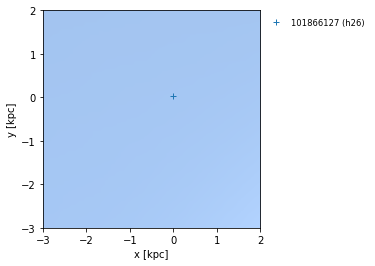

In [29]:
for j in reversed(snap_id_array[:-24]):
    weird_11=int(np.unique(h_highz[int(np.array([int(BH_highz[np.where(BH_highz['iord']==101863883)]['amiga.grp'])]).T[0])]['amiga.grp']))
    snap_lowz, h_lowz, BH_lowz, BH_arm_lowz = snap_highz, h_highz, BH_highz, BH_arm_highz
    print 'loading new snap, %s...'%(j)
    snap_highz, h_highz, BH_highz, BH_arm_highz = do_all(j)
    
    b=pynbody.bridge.OrderBridge(snap_lowz,snap_highz)
    print 'Making Catalog...'
    cat=b.fuzzy_match_catalog(max_index=100)
    df=pd.DataFrame({'snap':[str(j)],'match':[cat[weird_11]]})
    h11_hist=pd.concat([h11_hist, df], axis=0, join='outer')
    h11_hist.to_csv('h_11_hist.csv', index=False)
    print h11_hist
    
    for i in BH_arm_highz['iord']:
        halo_id=int(np.unique(h_highz[int(np.array(int(BH_highz[np.where(BH_highz['iord']==i)]['amiga.grp'])))]['amiga.grp']))
        pynbody.analysis.halo.center(h_highz[halo_id,],mode='com');
        halo_id, span, halos, BHlocal=bhplotfilter(snap_highz, 100, BH_highz)
        
        BH_image(snap_highz, 100, h_highz, halo_id, j, BHlocal, BH_highz, view=View[0], f1=True, save=True)
        BH_image(snap_highz, 100, h_highz, halo_id, j, BHlocal, BH_highz, view=View[1], f1=True, save=True)
        
        BH_image(snap_highz, 30, h_highz, halo_id, j, BHlocal, BH_highz, view=View[0], f1=True, save=True)
        BH_image(snap_highz, 30, h_highz, halo_id, j, BHlocal, BH_highz, view=View[1], f1=True, save=True)
        
        BH_image(snap_highz, 15, h_highz, halo_id, j, BHlocal, BH_highz, view=View[0], f1=True, save=True)
        BH_image(snap_highz, 15, h_highz, halo_id, j, BHlocal, BH_highz, view=View[1], f1=True, save=True)
        
        BH_image(snap_highz, 5, h_highz, halo_id, j, BHlocal, BH_highz, view=View[0], f1=True, save=True)
        BH_image(snap_highz, 5, h_highz, halo_id, j, BHlocal, BH_highz, view=View[1], f1=True, save=True)

In [28]:
#h11_hist=pd.DataFrame({'snap':[], 'match': []})
#df=pd.DataFrame({'snap':['4096'],'match':[(11, 1)]})
#h11_hist=pd.concat([h11_hist, df], axis=0, join='outer')
for j in reversed(snap_id_array[:-24]):
    print j

0275
0225
0139


In [27]:
df=pd.DataFrame({'snap':[str(j)],'match':[cat[weird_11]]})
h11_hist=pd.concat([h11_hist, df], axis=0, join='outer')

IndexError: list index out of range

In [ ]:
iord=BH_highz[np.isin(BH_highz['amiga.grp'],halo_id)]['iord']
iord = map(int, iord)
h_id=int(iords[-1:][str(iord[0])])

In [8]:
h11_hist=pd.read_csv('h_11_hist.csv')

In [18]:
int(np.unique(h_lowz[int(np.array([int(BH_lowz[np.where(BH_lowz['iord']==101863883)]['amiga.grp'])]).T[0])]['amiga.grp']))

44

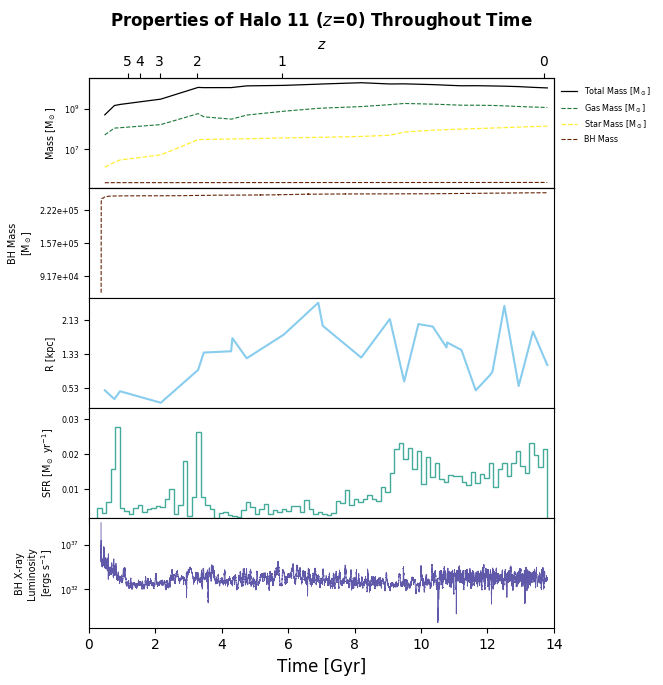

In [29]:
plot_all(i_101863883_data, adj_i101863883_orbit, time)#, save=True, filename='presentation_images/SMALLerrrr_h%s_plots.png')
plt.savefig('h11.png', dpi=1000, figsize=(3,3))

In [8]:
vars()['i_%s_data'%(101864796)]=pd.read_csv('csvdata/iord_%s.csv'%(101864796),index_col='snap')
vars()['adj_i%s_orbit'%(101864796)]=pd.read_csv('~/adj_i%s_orbit.csv'%(101863883))

In [12]:
#masses,iords=load_snap_csvs(snap_id_array[snap_id])
#global iords_list
#iords_list=iords.columns.tolist()
#iords_list=map(int, iords_list)
time=pd.read_csv('csvdata/time.csv', index_col=0)
global time_axis
time_axis=pd.read_csv('csvdata/time_axis.csv', index_col=0)

In [1]:
x=1

In [7]:
if y==False:
    print 'y not initiated'
else:
    print 'y=%s'%(y)

NameError: name 'y' is not defined

In [13]:
try: var3
except NameError:
    var3=[]
    print var3
var3=[1,2]
print var3

[]
[1, 2]
